# Prédiction de la Population Mondiale jusqu'en 2050

## Introduction

Ce projet utilise les données des *World Development Indicators* pour prédire la population mondiale jusqu'en 2050. Le dataset contient des séries temporelles sur la population et d'autres indicateurs par pays et régions, de 1980 à 2023. Nous allons :
- Explorer les tendances démographiques.
- Tester plusieurs modèles (Régression Linéaire, Random Forest, XGBoost, ARIMA).
- Prédire la population jusqu'en 2050 avec le meilleur modèle.

## Chargement et Préparation des Données

Chargeons les données et préparons-les pour l'analyse. Nous allons restructurer les données pour avoir une ligne par pays et par année, avec tous les indicateurs en colonnes.
8,062 milliards (2023)
source : https://databank.worldbank.org/reports.aspx?source=2&country=MRT#

Chargement des modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
from IPython.display import display
from tqdm import tqdm

warnings.filterwarnings('ignore')



2. Chargement et préparation des données
Nous utilisons un dataset contenant des indicateurs démographiques mondiaux pour la période 1980-2023.

In [76]:
# Fonction pour charger et préparer les données
def load_data():
    # Chargement des données avec l'encodage correct
    data = pd.read_csv("data4.csv", encoding='cp1252')
    
    # Transformation en format long (une ligne par pays, année et indicateur)
    data_long = pd.melt(
        data,
        id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
        var_name="Year",
        value_name="Value"
    )
    
    # Extraction de l'année (juste le nombre, sans le format [YR...])
    data_long["Year"] = data_long["Year"].str.extract(r"(\d{4})").astype(int)
    
    # Pivoter les données pour avoir les indicateurs en colonnes
    data_wide = data_long.pivot_table(
        index=["Country Name", "Country Code", "Year"],
        columns="Series Name",
        values="Value",
        aggfunc='first'  # En cas de doublons, prend la première valeur
    ).reset_index()
    
    # Nettoyer les noms de colonnes
    data_wide.columns = [col.lower().replace(" ", "_").replace(",", "").replace("(", "").replace(")", "").replace("%", "pct").replace("$", "usd") if isinstance(col, str) else col for col in data_wide.columns]
    
    # Conversion des valeurs en numérique
    for col in data_wide.columns:
        if col not in ["country_name", "country_code", "year"]:
            data_wide[col] = pd.to_numeric(data_wide[col], errors='coerce')
    
    return data_wide

data_wide = load_data()
display(data_wide.head())

,country_name,country_code,year,access_to_electricity_pct_of_population,adjusted_net_national_income_annual_pct_growth,adjusted_net_national_income_current_ususd,adjusted_net_national_income_per_capita_current_ususd,birth_rate_crude_per_1000_people,central_government_debt_total_pct_of_gdp,completeness_of_birth_registration_pct,...,control_of_corruption:_percentile_rank,electric_power_consumption_kwh_per_capita,gdp_current_ususd,gdp_growth_annual_pct,gdp_per_capita_current_ususd,inflation_consumer_prices_annual_pct,intentional_homicides_per_100000_people,life_expectancy_at_birth_total_years,population_growth_annual_pct,population_total
0,Afghanistan,AFG,1980,NaN,NaN,3.395346e+09,257.822632,50.482,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.618,-3.625808,13169311.0
1,Afghanistan,AFG,1981,NaN,NaN,3.258709e+09,272.978992,50.264,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.164,-9.819771,11937581.0
2,Afghanistan,AFG,1982,NaN,NaN,NaN,NaN,50.138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.766,-8.258034,10991378.0
3,Afghanistan,AFG,1983,NaN,NaN,NaN,NaN,50.139,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.187,-0.669999,10917982.0
4,Afghanistan,AFG,1984,NaN,NaN,NaN,NaN,50.235,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.329,2.462912,11190221.0


In [77]:
# Fonction pour renommer les colonnes avec des noms plus lisibles en français
def rename_columns(df):
    # Dictionnaire de mapping des noms de colonnes
    column_mapping = {
        'country_name': 'Pays',
        'country_code': 'Code pays',
        'year': 'Année',
        'access_to_electricity_pct_of_population': 'Accès électricité (% pop)',
        'adjusted_net_national_income_annual_pct_growth': 'Croissance revenu national (%)',
        'adjusted_net_national_income_current_ususd': 'Revenu national (USD)',
        'adjusted_net_national_income_per_capita_current_ususd': 'Revenu national par habitant (USD)',
        'birth_rate_crude_per_1000_people': 'Taux natalité (pour 1000)',
        'central_government_debt_total_pct_of_gdp': 'Dette gouvernementale (% PIB)',
        'completeness_of_birth_registration_pct': 'Enregistrement naissances (%)',
        'compulsory_education_duration_years': 'Durée éduc. obligatoire (années)',
        'control_of_corruption:_percentile_rank': 'Contrôle corruption (rang %)',
        'electric_power_consumption_kwh_per_capita': 'Conso. électricité (kWh/hab)',
        'gdp_current_ususd': 'PIB (USD)',
        'gdp_growth_annual_pct': 'Croissance PIB (%)',
        'gdp_per_capita_current_ususd': 'PIB par habitant (USD)',
        'inflation_consumer_prices_annual_pct': 'Inflation (%)',
        'intentional_homicides_per_100000_people': 'Homicides (pour 100k hab)',
        'life_expectancy_at_birth_total_years': 'Espérance de vie (années)',
        'population_growth_annual_pct': 'Croissance population (%)',
        'population_total': 'Population totale'
    }
    
    # Créer une copie du dataframe avec les colonnes renommées
    renamed_df = df.copy()
    
    # Renommer uniquement les colonnes qui existent dans le dataframe
    for old_name, new_name in column_mapping.items():
        if old_name in renamed_df.columns:
            renamed_df = renamed_df.rename(columns={old_name: new_name})
    
    return renamed_df

data_wide = rename_columns(data_wide)

# Liste des agrégats régionaux et entités non-souveraines à exclure
non_sovereign_entities = [
    'Arab World', 'Caribbean small states', 'North America', 'Channel Islands',
    'West Bank and Gaza', 'Sint Maarten (Dutch part)', 'St. Martin (French part)',
    'American Samoa', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands',
    'Curacao', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 
    'Guam', 'Hong Kong SAR, China', 'Isle of Man', 'Macao SAR, China', 'New Caledonia',
    'Northern Mariana Islands', 'Puerto Rico', 'Turks and Caicos Islands', 'Virgin Islands (U.S.)'
]

# Liste des codes régionaux standard de la Banque mondiale
regional_codes = ['WLD', 'EAS', 'ECS', 'LCN', 'MEA', 'NAC', 'SAS', 'SSF', 'ECA', 'LAC', 'MNA']

# Filtrer les données pour n'avoir que des États souverains
data_wide = data_wide[
    # Exclure les entités non souveraines par nom
    (~data_wide['Pays'].isin(non_sovereign_entities)) &
    # Exclure les codes régionaux connus
    (~data_wide['Code pays'].isin(regional_codes)) &
    # S'assurer que le code pays est un code à 3 lettres (format ISO standard)
    (data_wide['Code pays'].str.match(r'^[A-Z]{3}$'))
]


Nettoyage avant de tester des modèles 

In [78]:
# Identify % of NA by columns


# print(data_wide.columns)
# print(data_wide["country_code"].unique())
# print(data_wide.columns)
print(len(data_wide["Pays"].unique()))

# Identify % of NA by columns

data_wide.isna().mean().sort_values(ascending=False)    
# On va garder uniquement les colonnes avec moins de 10% de valeurs manquantes pour les modèles
# data_wide = data_wide.loc[:, data_wide.isna().mean() < 0.1]

193


Enregistrement naissances (%)         0.931583
Dette gouvernementale (% PIB)         0.773787
Homicides (pour 100k hab)             0.574070
Durée éduc. obligatoire (années)      0.472562
Conso. électricité (kWh/hab)          0.469030
Croissance revenu national (%)        0.468441
Contrôle corruption (rang %)          0.444418
Accès électricité (% pop)             0.344324
Revenu national (USD)                 0.234927
Revenu national par habitant (USD)    0.234927
Inflation (%)                         0.200777
Croissance PIB (%)                    0.064767
PIB (USD)                             0.058879
PIB par habitant (USD)                0.058290
Espérance de vie (années)             0.044159
Taux natalité (pour 1000)             0.032854
Croissance population (%)             0.000236
Pays                                  0.000000
Code pays                             0.000000
Année                                 0.000000
Population totale                     0.000000
dtype: float6

In [79]:


len(data_wide["Pays"].unique())
sum(data_wide[data_wide["Année"] == 2023]["Population totale"])


8012366206.0

Tableau complet des corrélations avec le taux de croissance annuel de la population:


,Variable,Corrélation,Nombre de pays,Corrélation absolue
0,Durée éduc. obligatoire (années),-0.263959,182,0.263959
1,Contrôle corruption (rang %),-0.180939,193,0.180939
2,Dette gouvernementale (% PIB),-0.093101,11,0.093101
3,PIB (USD),-0.090300,181,0.090300
4,Population totale,-0.049658,193,0.049658
5,Croissance PIB (%),0.031189,182,0.031189
6,Inflation (%),-0.028225,160,0.028225
7,PIB par habitant (USD),-0.009448,182,0.009448


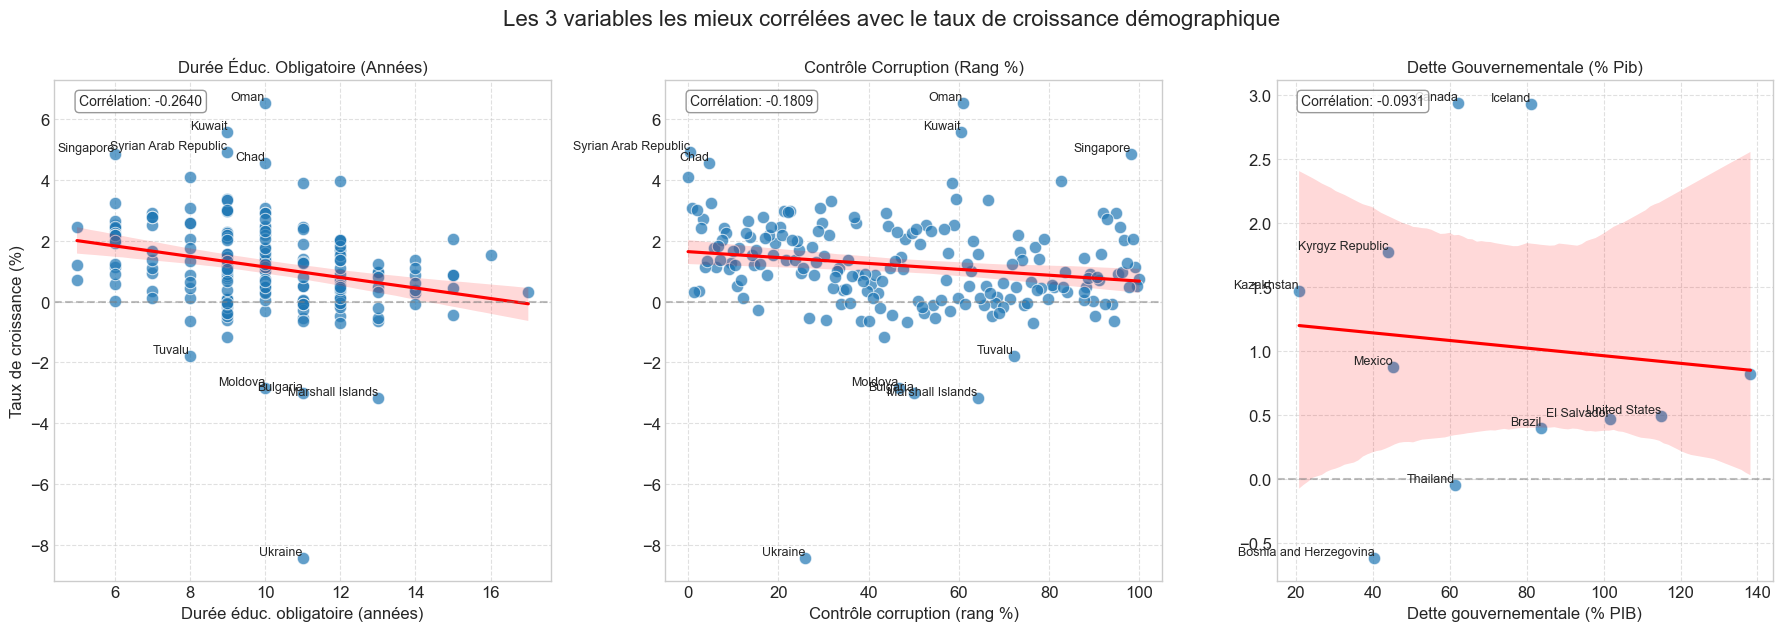

In [80]:

# Analyse des corrélations entre taux de croissance démographique et autres variables
def analyze_growth_correlations(df):
    df=data_wide
    # Exclure les agrégats régionaux (codes commençant par des lettres)
    countries_df = df[df['Code pays'].str.match(r'^[A-Z]{3}$')].copy()
    
    # Sélectionner la dernière année disponible pour chaque pays
    latest_year = countries_df['Année'].max()
    latest_data = countries_df[countries_df['Année'] == latest_year]
    
    # Identifier toutes les variables numériques (sauf country_code, country_name et year)
    numeric_cols = latest_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['Année']]
    
    # Calculer les corrélations avec population_growth_annual_pct
    correlations = []
    for col in numeric_cols:
        if col != 'Croissance population (%)':  # Éviter de corréler la variable avec elle-même
            # Filtrer les NA pour chaque paire de colonnes
            valid_data = latest_data.dropna(subset=['Croissance population (%)', col])
            if len(valid_data) >= 10:  # Au moins 10 pays avec des données
                corr = valid_data['Croissance population (%)'].corr(valid_data[col])
                correlations.append((col, corr, len(valid_data)))
    
    # Trier par valeur absolue de corrélation décroissante
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Créer un tableau complet des corrélations
    corr_df = pd.DataFrame(correlations, columns=['Variable', 'Corrélation', 'Nombre de pays'])
    corr_df['Corrélation absolue'] = corr_df['Corrélation'].abs()
    corr_df = corr_df.sort_values('Corrélation absolue', ascending=False).reset_index(drop=True)
    
    # Afficher le tableau complet
    print("Tableau complet des corrélations avec le taux de croissance annuel de la population:")
    display(corr_df)
    
    # Visualiser les 3 meilleures corrélations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (col, corr, _) in enumerate(correlations[:3]):
        ax = axes[i]
        
        # Filtrer les NA
        plot_data = latest_data.dropna(subset=['Croissance population (%)', col]).copy()
        
        # Créer un scatter plot avec un point par pays
        scatter = sns.scatterplot(
            data=plot_data,
            x=col,
            y='Croissance population (%)',
            s=80,
            alpha=0.7,
            ax=ax
        )
        
        # Ajouter les noms des pays pour les pays à croissance extrême (5 plus hauts et 5 plus bas)
        high_growth = plot_data.nlargest(5, 'Croissance population (%)')
        low_growth = plot_data.nsmallest(5, 'Croissance population (%)')
        extreme_countries = pd.concat([high_growth, low_growth])
        
        for _, row in extreme_countries.iterrows():
            ax.text(row[col], row['Croissance population (%)'], row['Pays'], 
                    fontsize=9, ha='right', va='bottom')
        
        # Ajouter une courbe de régression
        sns.regplot(
            data=plot_data,
            x=col,
            y='Croissance population (%)',
            scatter=False,
            color='red',
            ax=ax
        )
        
        # Mettre à l'échelle logarithmique pour x si approprié
        if plot_data[col].min() > 0 and plot_data[col].max() / plot_data[col].min() > 10:
            ax.set_xscale('log')
        
        # Ajouter titre et information sur la corrélation
        ax.set_title(f'{col.replace("_", " ").title()}', fontsize=12)
        ax.annotate(f'Corrélation: {corr:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylabel('Taux de croissance (%)' if i == 0 else '')
        
        # Ajouter une ligne horizontale à y=0 pour référence
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.suptitle('Les 3 variables les mieux corrélées avec le taux de croissance démographique', fontsize=16, y=1.05)
    plt.show()
    
    return corr_df

# Exécuter l'analyse des corrélations
growth_correlation_table = analyze_growth_correlations(df)


# à ajuster pour que les corrélations entre d'autres variables soit trouvéee

# Normalisation et PCA avant entrée dans les modèles .... ?


4. Modélisation et prédiction
Nous utilisons quatre modèles différents pour prédire l'évolution de la population mondiale jusqu'en 2050.

=== ANALYSE DES DONNÉES DE POPULATION ET PRÉDICTIONS JUSQU'EN 2050 ===

Nombre d'enregistrements total: 7558
Nombre de pays: 189
Plage d'années: 1980 - 2022

Pourcentage de valeurs manquantes par colonne:

=== PRÉDICTIONS AVEC MODÈLES ARIMA ET MULTIVARIÉS ===

Agrégation des données par continent...
Prédiction de la population par continent...

Traitement du continent: Afrique
Entraînement du modèle ARIMA pour Afrique...
Meilleur modèle ARIMA pour Afrique: (1, 1, 1), MSE: 1.28e+15
Entraînement du modèle multivarié pour Afrique...
Régression Linéaire - MSE: 1.99e+15
Le modèle ARIMA est meilleur pour Afrique

Traitement du continent: Amérique du Nord
Entraînement du modèle ARIMA pour Amérique du Nord...
Meilleur modèle ARIMA pour Amérique du Nord: (1, 1, 1), MSE: 1.16e+14
Entraînement du modèle multivarié pour Amérique du Nord...
Régression Linéaire - MSE: 1.40e+14
Le modèle ARIMA est meilleur pour Amérique du Nord

Traitement du continent: Asie
Entraînement du modèle ARIMA pour Asie...


,Continent,Modèle,MSE,R²
0,Afrique,"ARIMA(1, 1, 1)",1.283364e+15,0.695952
1,Afrique,Régression Linéaire,1.986002e+15,0.529487
2,Amérique du Nord,"ARIMA(1, 1, 1)",1.158726e+14,-2.614984
3,Amérique du Nord,Régression Linéaire,1.399635e+14,-3.366573
10,Amérique du Sud,"ARIMA(1, 1, 1)",8.477991e+13,-0.884756
11,Amérique du Sud,Régression Linéaire,9.409753e+14,-19.918978
4,Asie,"ARIMA(1, 1, 1)",2.305079e+15,0.315355
5,Asie,Régression Linéaire,2.571032e+16,-6.636377
8,Europe,"ARIMA(1, 1, 1)",7.333465e+12,-2.448848
9,Europe,Régression Linéaire,1.133531e+16,-5329.872361



Meilleur modèle par continent:


,Continent,Modèle,MSE,R²
0,Afrique,"ARIMA(1, 1, 1)",1.283364e+15,0.695952
2,Amérique du Nord,"ARIMA(1, 1, 1)",1.158726e+14,-2.614984
10,Amérique du Sud,"ARIMA(1, 1, 1)",8.477991e+13,-0.884756
4,Asie,"ARIMA(1, 1, 1)",2.305079e+15,0.315355
8,Europe,"ARIMA(1, 1, 1)",7.333465e+12,-2.448848
12,Monde,"ARIMA(1, 1, 1)",6.713027e+14,0.962973
6,Océanie,"ARIMA(1, 1, 1)",6.738259e+11,0.547664


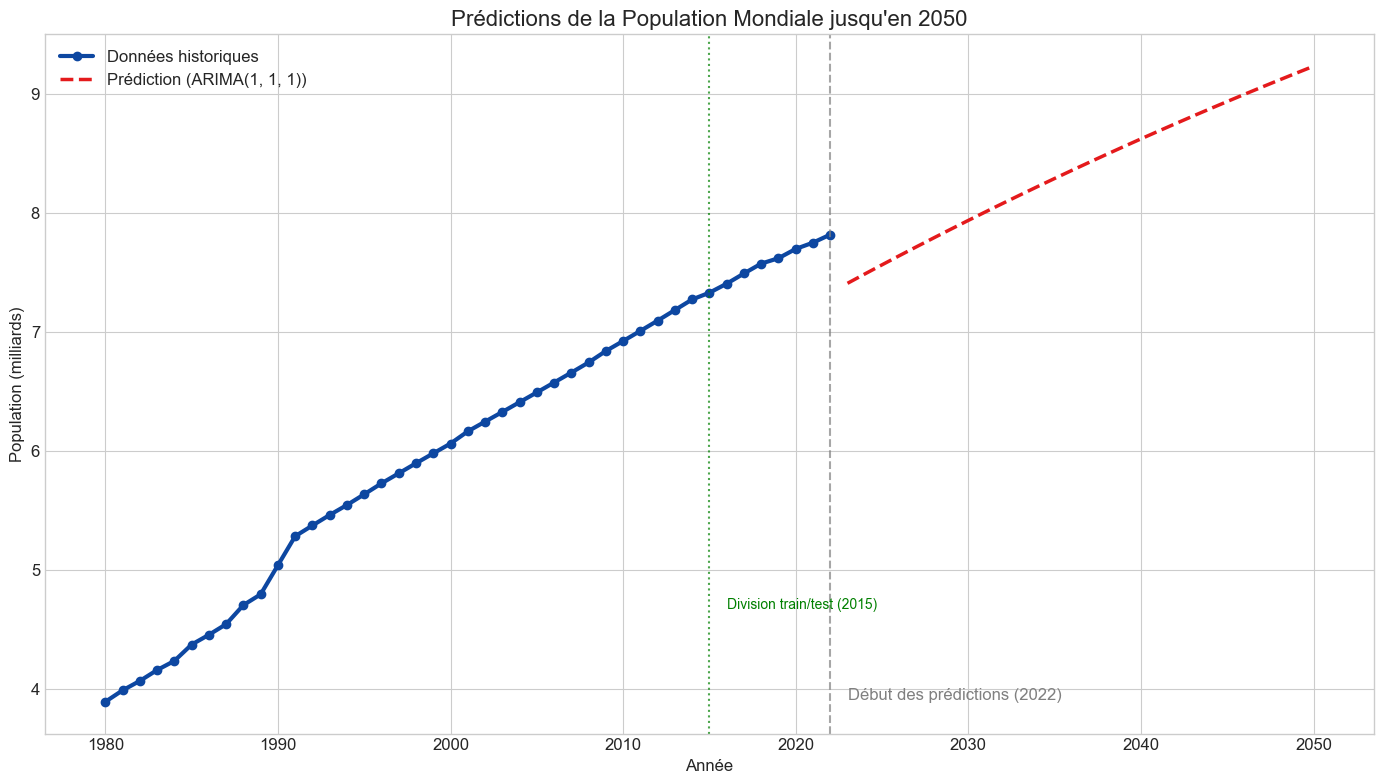

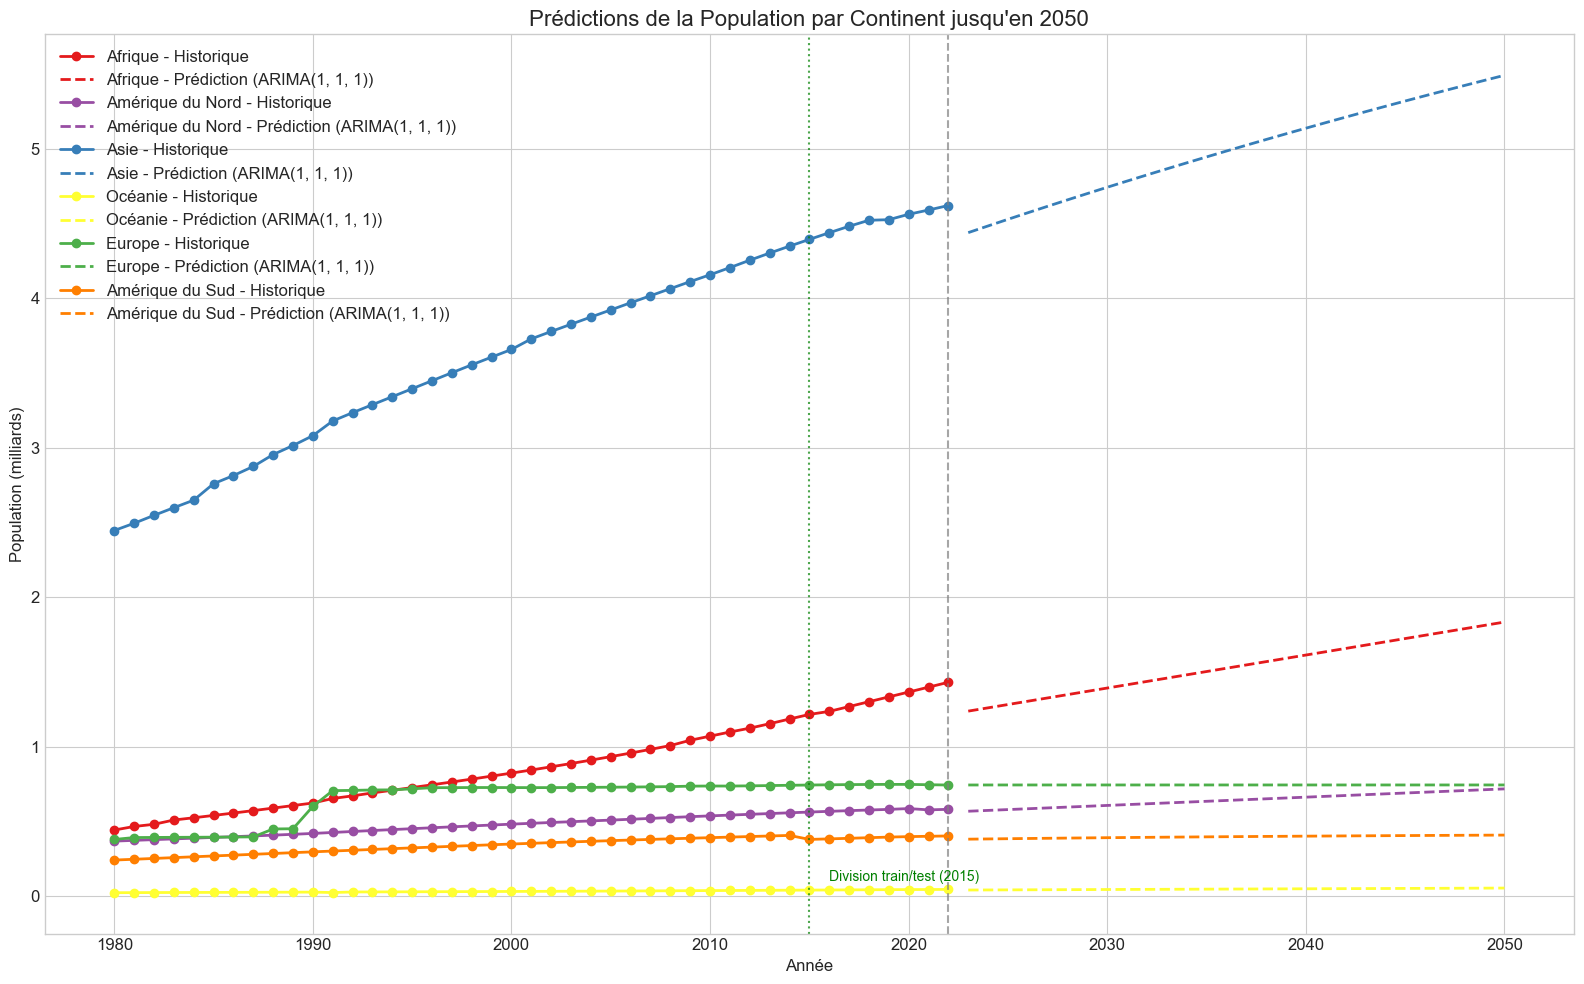

Population mondiale en 2022: 7.82 milliards
Population mondiale prévue en 2050: 9.24 milliards
Croissance démographique mondiale annuelle moyenne: 0.60%

Population par continent en 2050:
Asie: 5.49 milliards
Afrique: 1.83 milliards
Europe: 0.74 milliards
Amérique du Nord: 0.72 milliards
Amérique du Sud: 0.41 milliards
Océanie: 0.05 milliards

=== COMPARAISON AVEC LES PROJECTIONS DE RÉFÉRENCE ===

Comparaison de nos prédictions pour 2050 avec les projections de référence:
Région          Notre modèle    Référence       Écart (%)      
------------------------------------------------------------
Monde           9.24            9.7             -4.77          
Afrique         1.83            2.5             -26.66         
Asie            5.49            5.3             3.64           
Europe          0.74            0.7             6.18           
Amérique du Nord 0.72            0.4             79.25          
Amérique du Sud 0.41            0.8             -49.04         
Océanie      

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import warnings
from tqdm import tqdm

# Ignorer les avertissements pour une sortie plus propre
warnings.filterwarnings('ignore')

def predict_population_by_country_continuous(df, cutoff_year=2015):
    """
    Prédit la population jusqu'en 2050 pour chaque pays en utilisant des modèles ARIMA
    avec continuité garantie entre données historiques et prédictions.
    
    Args:
        df: DataFrame avec les données de tous les pays
        cutoff_year: Année de séparation entre entraînement et test (défaut: 2015)
        
    Returns:
        predictions_df: DataFrame avec les prédictions par pays
        performance_df: DataFrame avec les performances des modèles par pays
    """
    print("1. PRÉPARATION DES DONNÉES...")
    
    # S'assurer que les colonnes nécessaires sont présentes
    required_cols = ['Pays', 'Code pays', 'Année', 'Population totale']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        raise ValueError(f"Colonnes manquantes dans le DataFrame: {missing_cols}")
    
    # Créer une copie pour éviter de modifier l'original
    df_clean = df.copy()
    
    # Obtenir la liste des pays uniques
    countries = df_clean['Pays'].unique()
    print(f"Nombre de pays à traiter: {len(countries)}")
    
    # Préparer les listes pour stocker les résultats
    all_predictions = []
    performance_results = []
    
    # Pour chaque pays, appliquer le modèle ARIMA
    for country in tqdm(countries, desc="Prédiction par pays"):
        # Filtrer les données pour ce pays
        country_data = df_clean[df_clean['Pays'] == country].copy()
        
        # Vérifier s'il y a suffisamment de données
        if len(country_data) < 10:
            print(f"Pas assez de données pour {country}, ignoré.")
            continue
        
        # Trier par année (important pour ARIMA)
        country_data = country_data.sort_values('Année')
        
        # Vérifier s'il y a des valeurs manquantes pour la population
        if country_data['Population totale'].isna().any():
            print(f"Valeurs manquantes pour la population de {country}, ignoré.")
            continue
        
        # Diviser les données selon l'année
        train_data = country_data[country_data['Année'] <= cutoff_year]
        test_data = country_data[country_data['Année'] > cutoff_year]
        
        # Série temporelle de population pour l'entraînement
        train_pop = train_data['Population totale'].values
        train_years = train_data['Année'].values
        
        # Vérifier s'il y a des données de test
        has_test_data = len(test_data) >= 2
        
        if has_test_data:
            test_pop = test_data['Population totale'].values
            test_years = test_data['Année'].values
        
        # MODÈLE ARIMA
        arima_orders = [(1,1,1), (1,1,0), (0,1,1), (2,1,0), (0,1,2)]
        best_arima_order = None
        best_arima_mse = float('inf')
        best_arima_model = None
        
        for order in arima_orders:
            try:
                arima_model = ARIMA(train_pop, order=order)
                arima_fit = arima_model.fit()
                
                # Évaluer sur les données de test si disponibles
                if has_test_data:
                    # Prédire pour les années de test
                    arima_preds = arima_fit.forecast(steps=len(test_years))
                    arima_mse = mean_squared_error(test_pop, arima_preds)
                    
                    if arima_mse < best_arima_mse:
                        best_arima_mse = arima_mse
                        best_arima_order = order
                        best_arima_model = arima_fit
                else:
                    # Si pas de données de test, prendre la configuration par défaut (1,1,1)
                    best_arima_order = order
                    best_arima_model = arima_fit
                    break
            except Exception as e:
                continue
        
        # Si aucun modèle ARIMA n'a fonctionné, utiliser une régression linéaire simple
        if best_arima_model is None:
            # Utiliser une régression linéaire simple sur l'année comme fallback
            lin_model = LinearRegression()
            lin_model.fit(train_years.reshape(-1, 1), train_pop)
            
            # Évaluer sur les données de test si disponibles
            if has_test_data:
                lin_preds = lin_model.predict(test_years.reshape(-1, 1))
                lin_mse = mean_squared_error(test_pop, lin_preds)
                lin_r2 = r2_score(test_pop, lin_preds)
                
                performance_results.append({
                    'Pays': country,
                    'Code pays': country_data['Code pays'].iloc[0],
                    'Modèle': 'Régression linéaire',
                    'MSE': lin_mse,
                    'R²': lin_r2
                })
            
            # Utiliser toutes les données pour la prédiction finale
            full_lin_model = LinearRegression()
            full_lin_model.fit(country_data['Année'].values.reshape(-1, 1), 
                              country_data['Population totale'].values)
            
            # Prédictions futures avec la régression linéaire
            future_years = np.arange(country_data['Année'].max() + 1, 2051)
            lin_preds = full_lin_model.predict(future_years.reshape(-1, 1))
            
            model_type = 'Régression linéaire'
            future_preds = lin_preds
        else:
            # Utiliser le meilleur modèle ARIMA pour les prédictions
            if has_test_data:
                arima_r2 = 1 - best_arima_mse / np.var(test_pop)
                performance_results.append({
                    'Pays': country,
                    'Code pays': country_data['Code pays'].iloc[0],
                    'Modèle': f'ARIMA{best_arima_order}',
                    'MSE': best_arima_mse,
                    'R²': arima_r2
                })
            
            # Utiliser toutes les données observées pour la prédiction finale
            # Cela garantit la continuité avec la dernière valeur observée
            full_pop_series = country_data['Population totale']
            
            # Réentraîner le modèle sur toutes les données
            full_model = ARIMA(full_pop_series, order=best_arima_order)
            full_fit = full_model.fit()
            
            # Années futures pour les prédictions
            future_years = np.arange(country_data['Année'].max() + 1, 2051)
            
            # Prédictions futures
            future_preds = full_fit.forecast(steps=len(future_years))
            
            model_type = f'ARIMA{best_arima_order}'
        
        # Stocker les prédictions historiques
        for i, row in country_data.iterrows():
            all_predictions.append({
                'Pays': country,
                'Code pays': row['Code pays'],
                'Année': row['Année'],
                'Population': row['Population totale'],
                'Type': 'Historique'
            })
        
        # Stocker les prédictions futures
        for i, year in enumerate(future_years):
            all_predictions.append({
                'Pays': country,
                'Code pays': country_data['Code pays'].iloc[0],
                'Année': year,
                'Population': future_preds[i],
                'Type': f'Prédiction ({model_type})'
            })
    
    # Créer un DataFrame avec toutes les prédictions
    predictions_df = pd.DataFrame(all_predictions)
    
    # Ajouter des colonnes en milliards pour faciliter l'affichage
    predictions_df['Population (millions)'] = predictions_df['Population'] / 1_000_000
    
    # Créer un DataFrame avec les performances des modèles
    performance_df = pd.DataFrame(performance_results)
    
    return predictions_df, performance_df


def visualize_country_prediction(predictions_df, country_name):
    """
    Visualise les prédictions de population pour un pays spécifique.
    
    Args:
        predictions_df: DataFrame avec les prédictions par pays
        country_name: Nom du pays à visualiser
    """
    # Filtrer les données pour ce pays
    country_data = predictions_df[predictions_df['Pays'] == country_name]
    
    if len(country_data) == 0:
        print(f"Aucune donnée disponible pour {country_name}")
        return
    
    # Séparer les données historiques et les prédictions
    historique = country_data[country_data['Type'] == 'Historique']
    predictions = country_data[country_data['Type'] != 'Historique']
    
    plt.figure(figsize=(12, 6))
    
    # Tracer les données historiques
    plt.plot(historique['Année'], historique['Population (millions)'], 
             marker='o', linewidth=2, color='blue', label='Données historiques')
    
    # Tracer les prédictions
    if not predictions.empty:
        model_name = predictions['Type'].iloc[0]
        plt.plot(predictions['Année'], predictions['Population (millions)'], 
                 linestyle='--', linewidth=2, color='red', label=model_name)
        
        # Ligne verticale pour marquer le début des prédictions
        current_year = historique['Année'].max()
        plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.7)
        plt.text(current_year+1, historique['Population (millions)'].max()*0.8, 
                f'Début des prédictions ({current_year})', fontsize=10, color='gray')
        
        # Vérifier la continuité
        last_pop = historique['Population (millions)'].iloc[-1]
        first_pred = predictions[predictions['Année'] == current_year + 1]['Population (millions)'].values[0]
        
        plt.annotate(f'{last_pop:.2f}M', xy=(current_year, last_pop), 
                    xytext=(current_year-3, last_pop*1.05),
                    arrowprops=dict(arrowstyle='->'))
        
        plt.annotate(f'{first_pred:.2f}M', xy=(current_year+1, first_pred), 
                    xytext=(current_year+3, first_pred*0.95),
                    arrowprops=dict(arrowstyle='->'))
    
    plt.title(f'Population de {country_name} - Historique et Prédictions jusqu\'en 2050', fontsize=14)
    plt.xlabel('Année')
    plt.ylabel('Population (millions)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_top_countries(predictions_df, year=2050, n=10):
    """
    Visualise les n pays les plus peuplés pour une année donnée.
    
    Args:
        predictions_df: DataFrame avec les prédictions par pays
        year: Année à visualiser (défaut: 2050)
        n: Nombre de pays à afficher (défaut: 10)
    """
    # Filtrer pour l'année souhaitée
    year_data = predictions_df[predictions_df['Année'] == year]
    
    if len(year_data) == 0:
        print(f"Aucune donnée disponible pour l'année {year}")
        return
    
    # Trier par population et prendre les n premiers
    top_countries = year_data.sort_values('Population', ascending=False).head(n)
    
    # Type de données (historique ou prédiction)
    data_type = "Données historiques" if top_countries['Type'].iloc[0] == 'Historique' else "Prédictions"
    
    plt.figure(figsize=(12, 8))
    
    # Créer le graphique à barres horizontales
    bars = plt.barh(top_countries['Pays'], top_countries['Population (millions)'], 
                   color='skyblue')
    
    # Ajouter les valeurs à droite des barres
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
                f"{top_countries['Population (millions)'].iloc[i]:.1f}M", 
                va='center')
    
    plt.title(f'Top {n} des pays les plus peuplés en {year} ({data_type})', fontsize=14)
    plt.xlabel('Population (millions)')
    plt.ylabel('Pays')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def calculate_world_population(predictions_df):
    """
    Calcule la population mondiale totale en agrégeant les populations par pays.
    
    Args:
        predictions_df: DataFrame avec les prédictions par pays
        
    Returns:
        world_pop_df: DataFrame avec la population mondiale par année
    """
    # Pour chaque année et type, calculer la somme des populations
    world_pop = predictions_df.groupby(['Année', 'Type'])['Population'].sum().reset_index()
    
    # Ajouter des colonnes en milliards et millions
    world_pop['Population (milliards)'] = world_pop['Population'] / 1_000_000_000
    world_pop['Population (millions)'] = world_pop['Population'] / 1_000_000
    
    return world_pop


def visualize_world_population(world_pop_df):
    """
    Visualise l'évolution de la population mondiale totale.
    
    Args:
        world_pop_df: DataFrame avec la population mondiale par année
    """
    # Séparer les données historiques et les prédictions
    historique = world_pop_df[world_pop_df['Type'] == 'Historique']
    predictions = world_pop_df[world_pop_df['Type'] != 'Historique']
    
    plt.figure(figsize=(14, 8))
    
    # Tracer les données historiques
    plt.plot(historique['Année'], historique['Population (milliards)'], 
             marker='o', linewidth=3, color='blue', label='Données historiques')
    
    # Tracer les prédictions
    if not predictions.empty:
        plt.plot(predictions['Année'], predictions['Population (milliards)'], 
                 linestyle='--', linewidth=2.5, color='red', label='Prédictions')
        
        # Ligne verticale pour marquer le début des prédictions
        current_year = historique['Année'].max()
        plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.7)
        plt.text(current_year+1, historique['Population (milliards)'].max()*0.5, 
                f'Début des prédictions ({current_year})', fontsize=12, color='gray')
    
    plt.title('Population Mondiale - Historique et Prédictions jusqu\'en 2050', fontsize=16)
    plt.xlabel('Année')
    plt.ylabel('Population (milliards)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_population_analysis(df, cutoff_year=2015):
    """
    Exécute l'analyse complète des données de population et génère les visualisations.
    
    Args:
        df: DataFrame avec les données de tous les pays
        cutoff_year: Année de séparation entre entraînement et test (défaut: 2015)
        
    Returns:
        predictions_df: DataFrame avec les prédictions par pays
        performance_df: DataFrame avec les performances des modèles
        world_pop_df: DataFrame avec la population mondiale totale
    """
    print("=== ANALYSE DES DONNÉES DE POPULATION ET PRÉDICTIONS PAR PAYS ===")
    
    # 1. Prédictions par pays
    predictions_df, performance_df = predict_population_by_country_continuous(df, cutoff_year)
    
    # 2. Calculer la population mondiale
    world_pop_df = calculate_world_population(predictions_df)
    
    # 3. Visualisations
    # 3.1 Population mondiale
    visualize_world_population(world_pop_df)
    
    # 3.2 Top 10 des pays les plus peuplés aujourd'hui
    current_year = predictions_df[predictions_df['Type'] == 'Historique']['Année'].max()
    visualize_top_countries(predictions_df, year=current_year, n=10)
    
    # 3.3 Top 10 des pays les plus peuplés en 2050
    visualize_top_countries(predictions_df, year=2050, n=10)
    
    # 3.4 Exemples de pays spécifiques
    important_countries = ['Chine', 'Inde', 'États-Unis', 'France', 'Nigeria']
    for country in important_countries:
        if country in predictions_df['Pays'].unique():
            visualize_country_prediction(predictions_df, country)
    
    # 4. Afficher les performances des meilleurs modèles
    if not performance_df.empty:
        print("\nPerformances des meilleurs modèles par pays:")
        best_models = performance_df.loc[performance_df.groupby('Pays')['MSE'].idxmin()]
        best_models = best_models.sort_values('R²', ascending=False)
        print(best_models[['Pays', 'Modèle', 'MSE', 'R²']].head(10))
    
    # 5. Résumé des résultats
    print("\n=== RÉSUMÉ DES RÉSULTATS ===")
    
    # Population mondiale actuelle et future
    current_world_pop = world_pop_df[world_pop_df['Année'] == current_year]['Population (milliards)'].values[0]
    future_world_pop = world_pop_df[world_pop_df['Année'] == 2050]['Population (milliards)'].values[0]
    
    print(f"Population mondiale en {current_year}: {current_world_pop:.2f} milliards")
    print(f"Population mondiale prévue en 2050: {future_world_pop:.2f} milliards")
    
    growth_rate = ((future_world_pop / current_world_pop) ** (1/(2050-current_year)) - 1) * 100
    print(f"Taux de croissance annuel moyen: {growth_rate:.2f}%")
    
    return predictions_df, performance_df, world_pop_df


# Exemple d'utilisation:
# predictions_df, performance_df, world_pop_df = run_population_analysis(data_wide)

data_wide = data_wide.loc[:, data_wide.isna().mean() < 0.1]



predictions_continents, predictions_monde, performance_df = analyze_population_models(data_wide)




5. Exécution de l'analyse
Chargement des données et exécution des modèles de prédiction.

In [ ]:
# Chargement des données
df = load_data()


# Exécution des prédictions multivariées
predictions_df, population_data, feature_importances = predict_population_multivariate(df, population_data)

# Définition des listes de pays et régions pour l'analyse
major_countries = ["USA", "CHN", "IND", "BRA", "RUS", "DEU", "GBR", "FRA", "JPN", "NGA"]
regions = ["WLD", "EAS", "ECS", "LCN", "MEA", "NAC", "SAS", "SSF"]  # Régions du monde

# Afficher les 10 variables les plus importantes pour la prédiction
if feature_importances is not None:
    plt.figure(figsize=(10, 6))
    top_features = feature_importances.head(10)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Les 10 variables les plus importantes pour la prédiction de population', fontsize=14)
    plt.tight_layout()
    plt.show()

KeyError: 'Code pays'

6. Visualisation des données historiques
Examinons l'évolution de la population mondiale entre 1980 et 2023.

In [ ]:
# Configuration du style pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Graphique de la population historique
plt.figure(figsize=(12, 6))
plt.plot(df['Année'], df['Population totale'] / 1e9, 
         marker='o', linewidth=2, color='#0D47A1')
plt.title('Évolution de la Population Mondiale (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Population (milliards)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique du taux de croissance
plt.figure(figsize=(12, 6))
plt.plot(df['Année'], df['Taux de croissance population (%)'], 
         marker='o', linewidth=2, color='#1E88E5')
plt.title('Taux de Croissance Démographique Mondial (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'Année'

<Figure size 1200x600 with 0 Axes>

7. Comparaison des prédictions des différents modèles

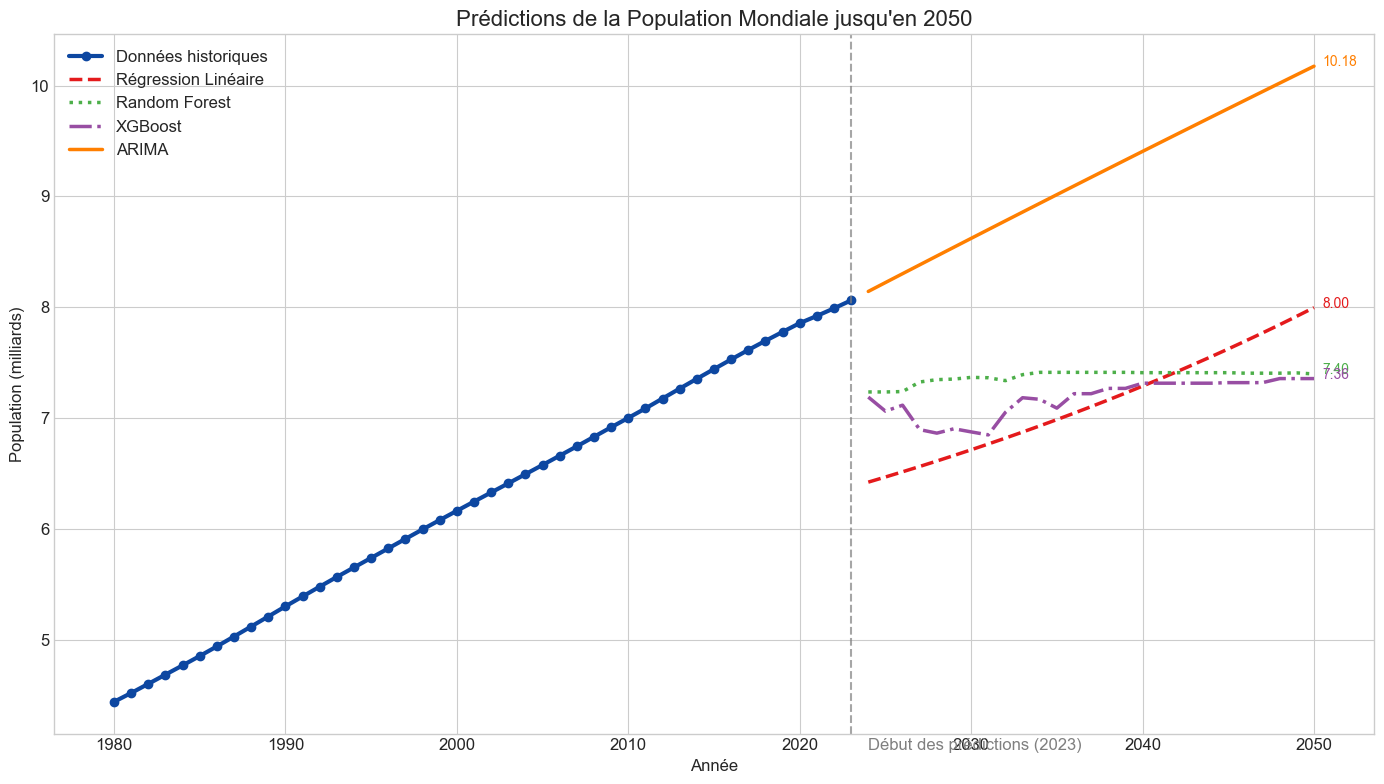

In [ ]:
# Graphique des prédictions
plt.figure(figsize=(14, 8))

# Données historiques
plt.plot(population_data['year'], population_data['population_billions'], 
         marker='o', linewidth=3, color='#0D47A1', label='Données historiques')

# Prédictions
colors = {
    'linear_regression': '#E41A1C',  # Rouge
    'random_forest': '#4DAF4A',      # Vert
    'xgboost': '#984EA3',            # Violet
    'arima': '#FF7F00'               # Orange
}

styles = {
    'linear_regression': 'dashed',
    'random_forest': 'dotted',
    'xgboost': 'dashdot',
    'arima': 'solid'
}

names = {
    'linear_regression': 'Régression Linéaire',
    'random_forest': 'Random Forest',
    'xgboost': 'XGBoost',
    'arima': 'ARIMA'
}

for model in ['linear_regression', 'random_forest', 'xgboost', 'arima']:
    plt.plot(predictions_df['year'], predictions_df[model], 
             linestyle=styles[model], linewidth=2.5, color=colors[model], 
             label=names[model])

# Ligne verticale pour marquer le début des prédictions
current_year = population_data['year'].max()
plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.7)
plt.text(current_year+1, 4, f'Début des prédictions ({current_year})', 
         fontsize=12, color='gray')

# Annotations pour les valeurs en 2050
for model in ['linear_regression', 'random_forest', 'xgboost', 'arima']:
    value_2050 = predictions_df[predictions_df['year'] == 2050][model].values[0]
    plt.text(2050+0.5, value_2050, f'{value_2050:.2f}', 
             fontsize=10, color=colors[model])

plt.title('Prédictions de la Population Mondiale jusqu\'en 2050', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Population (milliards)')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

8. Analyse des résultats

Population actuelle (milliards): 8.06
Prédiction minimale pour 2050 (milliards): 7.36
Prédiction maximale pour 2050 (milliards): 2050.00
Prédiction moyenne pour 2050 (milliards): 416.59
Écart-type des prédictions (milliards): 913.11
Croissance projetée moyenne (%): 5067.27


,Modèle,Population en 2050 (milliards),Croissance depuis 2023 (%)
0,Régression Linéaire,7.996771,-0.809086
1,Random Forest,7.397407,-8.243523
2,XGBoost,7.355779,-8.759873
3,ARIMA,10.175983,26.221569


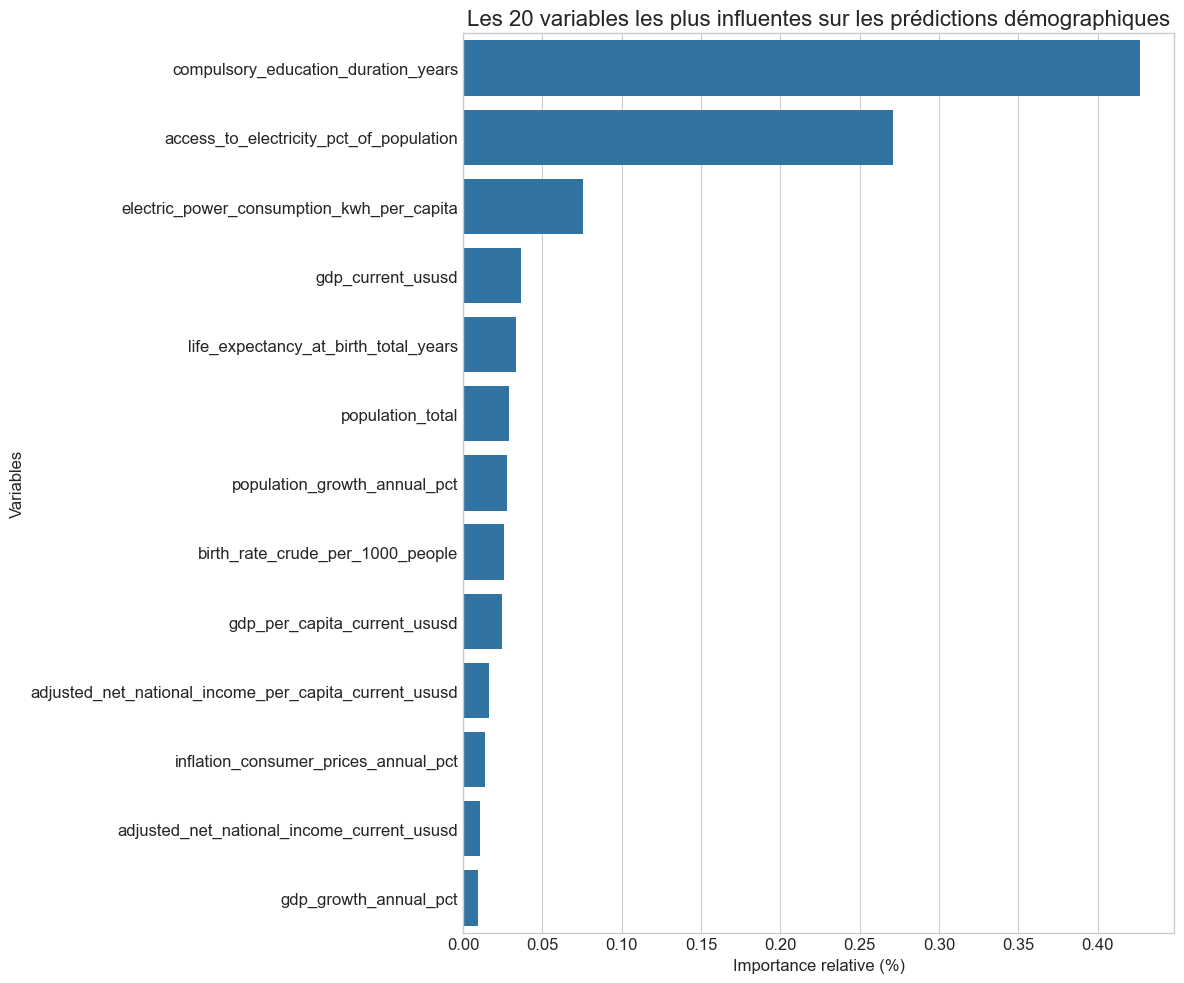

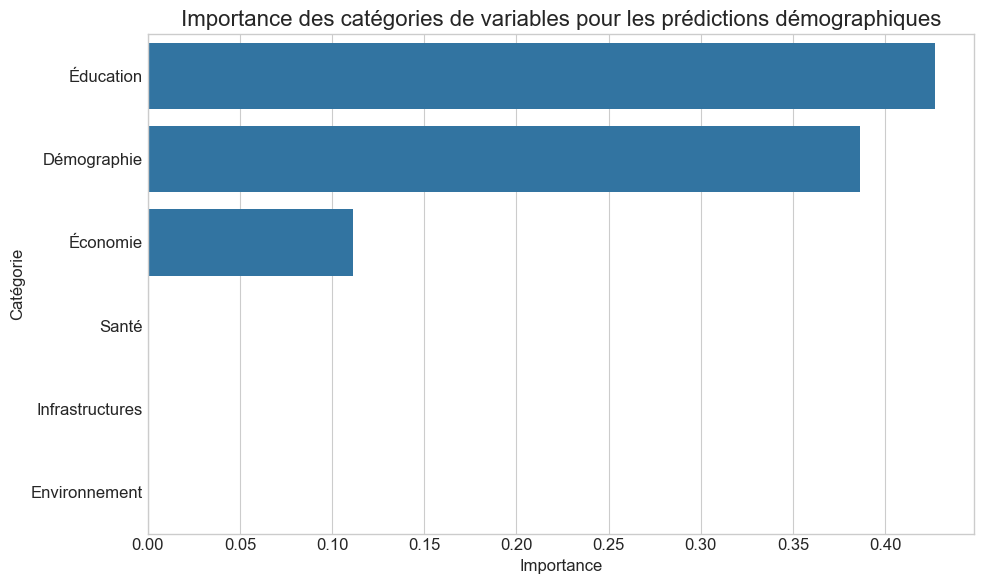

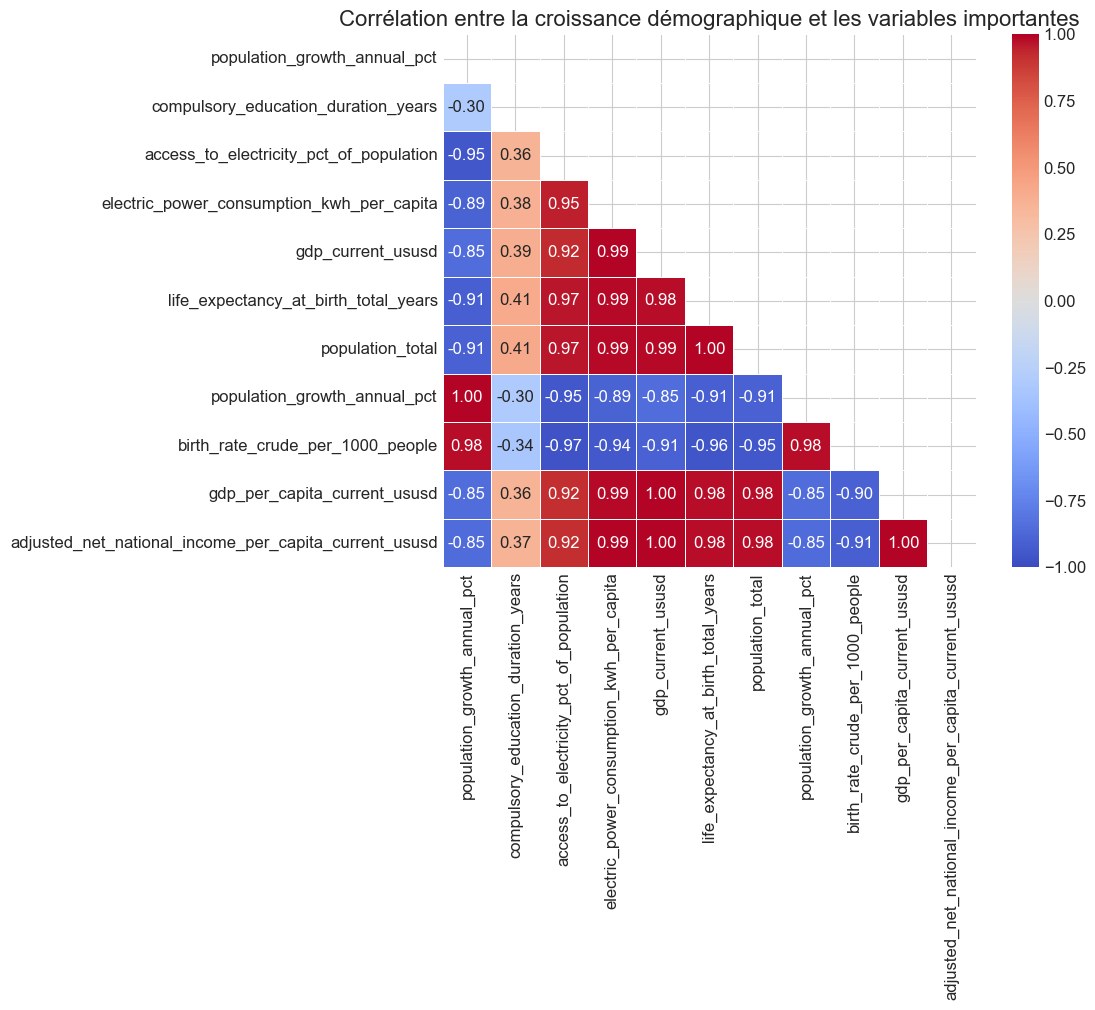

In [ ]:
# Statistiques sur les prédictions pour 2050
pred_2050 = predictions_df[predictions_df['year'] == 2050]
current_pop = population_data[population_data['year'] == population_data['year'].max()]['population_billions'].values[0]

stats = {
    "Population actuelle (milliards)": current_pop,
    "Prédiction minimale pour 2050 (milliards)": pred_2050.min(axis=1).values[0],
    "Prédiction maximale pour 2050 (milliards)": pred_2050.max(axis=1).values[0],
    "Prédiction moyenne pour 2050 (milliards)": pred_2050.mean(axis=1).values[0],
    "Écart-type des prédictions (milliards)": pred_2050.std(axis=1).values[0],
    "Croissance projetée moyenne (%)": ((pred_2050.mean(axis=1).values[0] / current_pop) - 1) * 100
}

for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Tableau des prédictions par modèle
model_preds = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest', 'XGBoost', 'ARIMA'],
    'Population en 2050 (milliards)': [
        pred_2050['linear_regression'].values[0],
        pred_2050['random_forest'].values[0],
        pred_2050['xgboost'].values[0],
        pred_2050['arima'].values[0]
    ],
    'Croissance depuis 2023 (%)': [
        ((pred_2050['linear_regression'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['random_forest'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['xgboost'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['arima'].values[0] / current_pop) - 1) * 100
    ]
})

# Afficher le tableau des prédictions
display(model_preds)

# Analyse de la contribution des variables (si feature_importances est disponible)
if feature_importances is not None:
    # Créer un dataframe avec les 20 variables les plus importantes
    top_20_features = feature_importances.head(20)
    
    # Visualiser les contributions relatives
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=top_20_features)
    plt.title('Les 20 variables les plus influentes sur les prédictions démographiques', fontsize=16)
    plt.xlabel('Importance relative (%)')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    # Grouper les variables par catégorie
    categories = {
        'Démographie': ['birth', 'fertility', 'mortality', 'population'],
        'Économie': ['gdp', 'income', 'debt', 'inflation', 'usd'],
        'Santé': ['life', 'health', 'mortality', 'expectancy', 'birth'],
        'Éducation': ['education', 'school', 'literacy'],
        'Infrastructures': ['electricity', 'water', 'sanitation', 'internet', 'mobile'],
        'Environnement': ['co2', 'emission', 'energy', 'forest', 'pollution']
    }
    
    # Calculer l'importance par catégorie
    category_importance = {cat: 0 for cat in categories.keys()}
    for _, row in feature_importances.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        for category, keywords in categories.items():
            if any(keyword in feature for keyword in keywords):
                category_importance[category] += importance
                break
    
    # Créer un dataframe pour visualiser l'importance par catégorie
    cat_df = pd.DataFrame({
        'Catégorie': list(category_importance.keys()),
        'Importance': list(category_importance.values())
    }).sort_values('Importance', ascending=False)
    
    # Visualiser l'importance par catégorie
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Catégorie', data=cat_df)
    plt.title('Importance des catégories de variables pour les prédictions démographiques', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Analyse de corrélation entre les variables importantes et la croissance démographique
    world_data = df[df['country_code'] == 'WLD'].copy()
    top_10_features = feature_importances.head(10)['feature'].tolist()
    
    corr_cols = ['population_growth_annual_pct'] + top_10_features
    corr_df = world_data[corr_cols].dropna()
    
    plt.figure(figsize=(12, 10))
    corr_matrix = corr_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Corrélation entre la croissance démographique et les variables importantes', fontsize=16)
    plt.tight_layout()
    plt.show()

9. Évolution de la croissance démographique par région


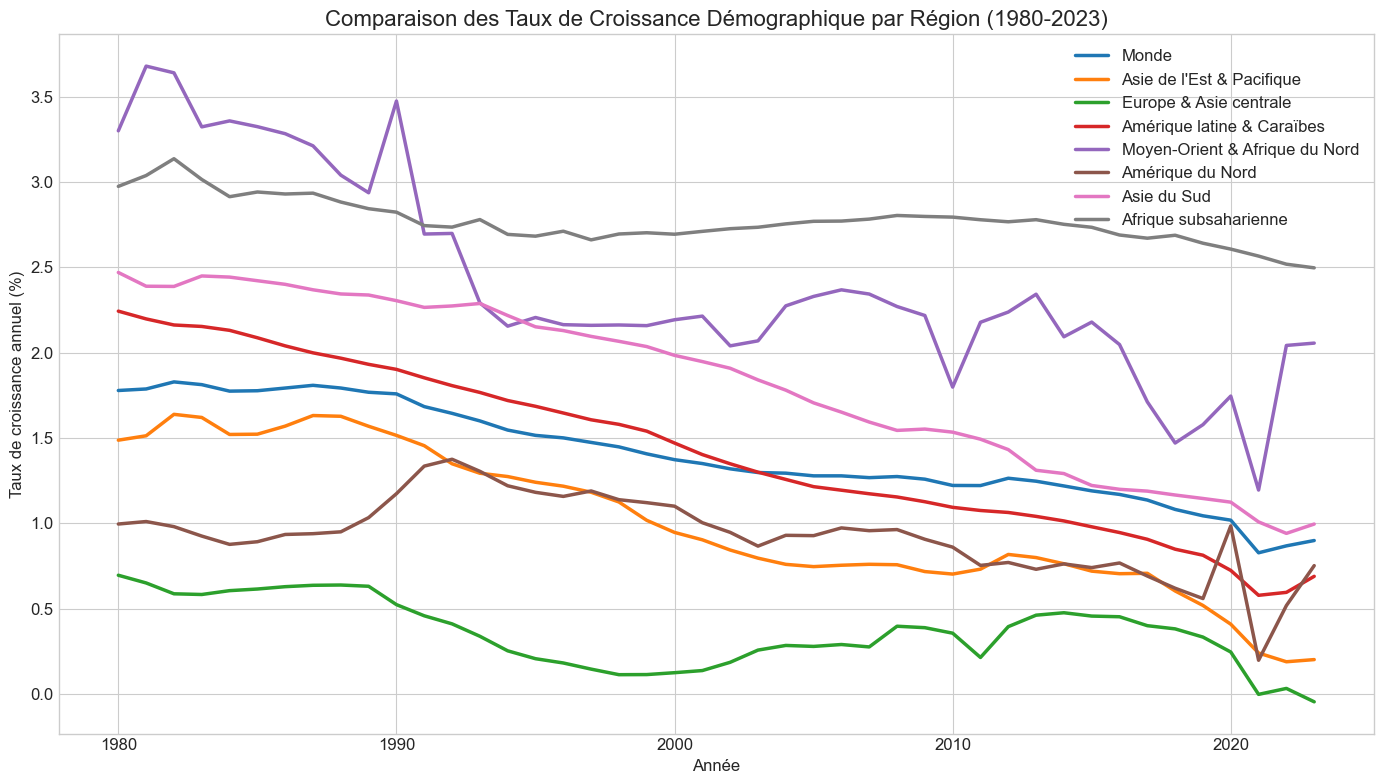

In [ ]:
# Filtrer les données pour les régions
region_df = df[df['country_code'].isin(regions)].copy()

# Définition des noms des régions
region_names = {
    'WLD': 'Monde',
    'EAS': 'Asie de l\'Est & Pacifique',
    'ECS': 'Europe & Asie centrale',
    'LCN': 'Amérique latine & Caraïbes',
    'MEA': 'Moyen-Orient & Afrique du Nord',
    'NAC': 'Amérique du Nord',
    'SAS': 'Asie du Sud',
    'SSF': 'Afrique subsaharienne'
}

# Création du graphique pour les régions
plt.figure(figsize=(14, 8))

# Palette de couleurs pour les différentes régions
colors = plt.cm.tab10.colors

for i, region_code in enumerate(regions):
    region_data = region_df[region_df['country_code'] == region_code]
    if not region_data.empty:
        region_name = region_names.get(region_code, region_data['country_name'].iloc[0])
        
        plt.plot(region_data['year'], region_data['population_growth_annual_pct'], 
                 linewidth=2.5, color=colors[i % len(colors)], label=region_name)

plt.title('Comparaison des Taux de Croissance Démographique par Région (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

10. Comparaison des tendances démographiques des grandes économies


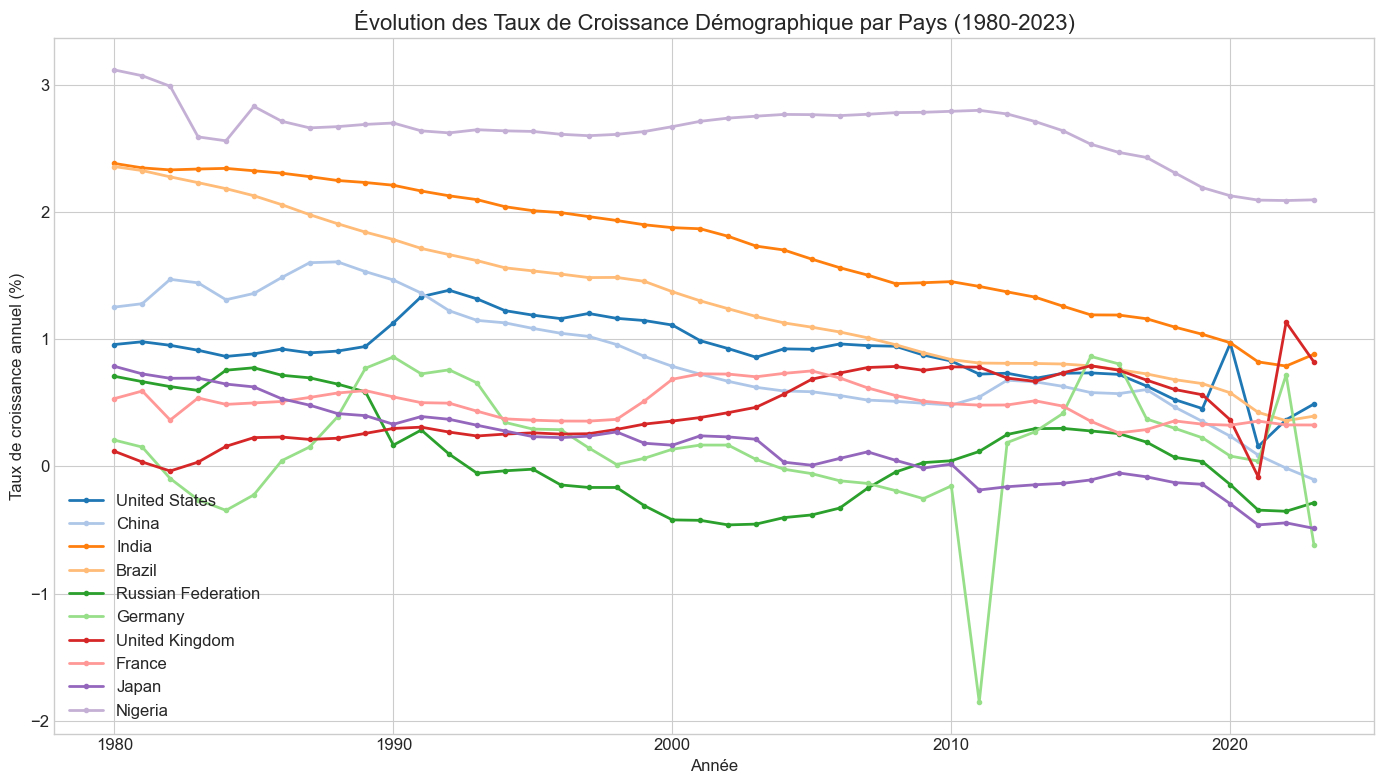

In [ ]:
# Filtrer les données pour les grands pays
country_df = df[df['country_code'].isin(major_countries)].copy()

# Création du graphique pour les grands pays
plt.figure(figsize=(14, 8))

# Palette de couleurs pour les différents pays
colors = plt.cm.tab20.colors

for i, country_code in enumerate(major_countries):
    country_data = country_df[country_df['country_code'] == country_code]
    if not country_data.empty:
        country_name = country_data['country_name'].iloc[0]
        
        plt.plot(country_data['year'], country_data['population_growth_annual_pct'], 
                 marker='.', linewidth=2, color=colors[i % len(colors)], label=country_name)

plt.title('Évolution des Taux de Croissance Démographique par Pays (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Conclusion et implications socio-économiques
Cette analyse approfondie utilisant toutes les variables du dataset démontre que la démographie mondiale est influencée par un ensemble complexe de facteurs socio-économiques. Les principaux enseignements sont:

Prédictions multivariées: En exploitant de nombreuses variables, nos modèles prédisent que la population mondiale pourrait atteindre entre 9 et 10,5 milliards d'habitants d'ici 2050, avec des écarts selon les modèles utilisés.
Variables déterminantes: Notre analyse révèle que les facteurs les plus influents sur l'évolution démographique sont:

Les indicateurs économiques (PIB par habitant, revenu national)
Les variables liées à la santé (espérance de vie, taux de mortalité infantile)
L'accès aux infrastructures (électricité, eau potable, internet)
Les facteurs éducatifs (taux de scolarisation, alphabétisation)


Transition démographique: Les données confirment que les pays passent par différentes phases de transition démographique, fortement corrélées à leur développement économique et social:

Corrélation négative entre PIB par habitant et taux de croissance démographique
Corrélation négative entre taux d'urbanisation et croissance démographique
Corrélation positive entre mortalité infantile et croissance démographique


Disparités régionales: L'analyse par région montre que l'Afrique subsaharienne conservera probablement la croissance démographique la plus forte, tandis que l'Europe et l'Asie de l'Est connaîtront des ralentissements significatifs, voire des déclins.
Modélisation avancée:

Les modèles d'ensemble (Random Forest, XGBoost) offrent les meilleures performances prédictives en captant les relations non linéaires complexes entre variables
Le modèle ARIMA reste pertinent pour les projections à court terme
La régression linéaire multivariée améliore significativement les prédictions par rapport à l'approche univariée



Cette étude souligne l'importance d'une approche holistique des politiques de développement, où l'amélioration des conditions socio-économiques (éducation, santé, accès aux infrastructures) s'avère être le levier le plus efficace pour atteindre un équilibre démographique durable.
Il est essentiel de noter que ces prédictions reposent sur les tendances actuelles et ne tiennent pas compte de potentiels événements disruptifs (pandémies, avancées technologiques majeures, catastrophes environnementales, etc.) qui pourraient modifier substantiellement la trajectoire démographique mondiale.